# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Описание данных

 - Name — название игры
 - Platform — платформа
 - Year_of_Release — год выпуска
 - Genre — жанр игры
 - NA_sales — продажи в Северной Америке (миллионы проданных копий)
 - EU_sales — продажи в Европе (миллионы проданных копий)
 - JP_sales — продажи в Японии (миллионы проданных копий)
 - Other_sales — продажи в других странах (миллионы проданных копий)
 - Critic_Score — оценка критиков (максимум 100)
 - User_Score — оценка пользователей (максимум 10)
 - Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Подготовка данных

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re

### Загрузка датасета

In [2]:
data = pd.read_csv('games.csv')

In [3]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим на количество пропусков в процентах:

In [5]:
data.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

Имеем пропуски в следующих столбцах:
 - Название игры (2 пропуска)
 - год релиза (69)
 - жанр (2)
 - оценка экспертов (больше 8 тысяч пропусков)
 - оценка игроков (6 тысяч пропусков)
 - возрастной рейтинг (7 тысяч)

Строки с пропусками названий и жанров мы удалим, потому что их никак не заменить. Год релиза попробуем вытащить из названия игр, где это возможно, или найти такую же игру, но на другой платформе. Или же возьмем медиану по платформе. Оценки экспертов и игроков оставим с пропусками. А возрастной рейтинг можно попробовать заполнить по жанру (например, если жанр экшн или шутер - можно поставить 18+. В спорте можно и 12+, а в условных пазлах  - 0+).

**Уже работая с данными, я обнаружил, что есть игра (по крайней мере одна точно), которая вышла на 19 лет раньше выхода консоли. Скорее всего, это изначально неверное значение. Поэтому в пунтке 1.4 я его заменю сразу на год выхода платформы.**

### Переименование столбцов

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Заполнение пропусков

Та самая игра из 1985:

In [8]:
data.query('name == "Strongest Tokyo University Shogi DS"') 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


In [9]:
fil1 = data['name'] != 'Strongest Tokyo University Shogi DS' # условие фильтра

In [10]:
data['year_of_release'] = data['year_of_release'].where(fil1, 2004.0) # замена

In [11]:
data.query('name == "Strongest Tokyo University Shogi DS"') # проверка

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15957,Strongest Tokyo University Shogi DS,DS,2004.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


#### Столбец name

In [12]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как видно, позиции, имеющие пропуск в названии, иметют так же пропуск в столбце genre. Здесь не получится ничем заменить пропуски, поэтому просто удалим.

In [13]:
data = data.dropna(subset = ['name'])

In [14]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


#### Год релиза

In [15]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В названиях некоторых игр фигурируют числа. Например, у спортивных симуляторов число в конце названия говорит о годе выпуска (FIFA 2008, NHL 2006 и т.д.). Можно попробовать найти эти числа в названиях и заполнить пропуски в year_of_release

Некоторые игры могут быть выпущены на различных платформах. И где-то год выпуска указан, а где-то нет. Это может быть связано с человеческим фактором. 

Попробуем найти игры с одинаковыми названиями: если такие есть и у всех при этом одинаковый год выпуска, то пропущенный год выхода этой игры заменим на аналогичный год у одноименной. Если же игры выходили в разное время на разных платформах, то пропущенный год заменим на год выхода платформы

In [16]:
def dublicates(row):
    if pd.isna(row['year_of_release']): #если есть пропуск в year_of_release
        name = row['name']
        platform = row['platform']
        lenght = len(data.query('name == @name'))
        if lenght > 1 and len(data.query('name == @name')['year_of_release'].value_counts()) == 1:
            row['year_of_release'] = data.query('name == @name').iloc[1]['year_of_release']
        else:
            if len(data.query('name == @name')['year_of_release'].value_counts()) != 1: 
                row['year_of_release'] = data.query('platform == @platform')['year_of_release'].min()
    return row

In [17]:
data = data.apply(dublicates, axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16651 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Теперь дубликатов, у части из которых не прописан год выпуска, нет. Но остались еще строки

In [19]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.00,0.27,73.0,7.4,E10+
1609,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,0.69,0.42,0.00,0.12,76.0,7.8,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16059,Dance! It's Your Stage,Wii,NaN,Misc,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.00,0.01,0.00,0.00,65.0,NaN,RP
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16329,Brothers in Arms: Furious 4,X360,NaN,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,M


Теперь попробуем найти в названии год и записать его в year_of_release

In [20]:
def search_year(row):
    if pd.isna(row['year_of_release']): #если есть пропуск в year_of_release
        year = re.search('\d{4}', row['name']) # ищем именно длину 4, потому что длина 3 никак не связана с годом
        if year:
            row['year_of_release'] = year[0]
    return row

In [21]:
data = data.apply(search_year, axis=1)

In [22]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.00,0.27,73.0,7.4,E10+
1609,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,0.69,0.42,0.00,0.12,76.0,7.8,E10+
2132,LEGO Harry Potter: Years 5-7,X360,NaN,Action,0.51,0.37,0.00,0.09,77.0,7.9,E10+
2273,LEGO Harry Potter: Years 5-7,PS3,NaN,Action,0.36,0.41,0.00,0.15,76.0,8.3,E10+
2361,Rhythm Heaven,Wii,NaN,Misc,0.11,0.00,0.77,0.01,NaN,NaN,NaN
2453,The Lord of the Rings: War in the North,X360,NaN,Action,0.52,0.24,0.00,0.08,61.0,7.4,M
2522,The Lord of the Rings: War in the North,PS3,NaN,Action,0.25,0.42,0.01,0.13,63.0,7,M


У нас все еще остаются строки с пропусками. Давайте заполним каждый пропуск **медианой** года релиза по играм, сгрупированным по **платформам**. 

In [23]:
def median_year(row):
    if pd.isna(row['year_of_release']): #если есть пропуск в year_of_release
        platform = row['platform']
        row['year_of_release'] = data.query('platform == @platform')['year_of_release'].median()
    return row    

In [24]:
data = data.apply(median_year, axis=1)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  object 
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


#### Рейтинг

In [26]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Википедия пишет о следующем:

    - E - everyone
    - T - teen для подростков
    - M - для взрослых
    - Е10+ - для лиц старше 10 лет
    - ЕС - Для детей младшего возраста
    - RP -рейтинг ожидается

Пропуски можно заполнить следующим образом: берем жанр, смотрим наиболее встречающийся рейтинг и заполняем им. Но мы сделаем это в пункте 3. Объясню почему: наиболее встречающийся рейтинг среди всего датафрейма - Т, а если мы берем актуальный период - то это М. Возможно, целевая аудитория в современных играх стала старше, или игры стали содержать больше сцен насилия

#### Выводы

Остались пропуски в следующих столбцах:

- оценках от экспертов и игроков. Пропуски могут быть обсуловлены малым количеством продаж (т.е. неинтересно игрокам), или игра может быть слишком старой, когда никто не оценивал игры. Или наоборот, игра вышла совсем недавно и игроки не успели оценить игру. Мне пока не очень хочется заменять пропуски на медианы, потому что оценка зависит не только от платформы и жанра, но и от студии, которая разрабатывает игры. Хотя, для проекта, может и достаточно двух параметров. Если это очень важно - я сделаю, когда буду исправлять ошибки =)
- возрастной рейтинг игры. Здесь можно заполнить пропуски в зависимости от жанра. 

### Изменение типов данных

Год можно преобразовать из float64 в Int64

In [27]:
data['year_of_release'] = data['year_of_release'].astype('int64')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Оценку пользователей также лучше перевести во float64, но в следующем пункте

### Изучение значений различных столбцов

In [29]:
data['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [30]:
data['year_of_release'].value_counts()

2009    1446
2008    1437
2010    1271
2007    1199
2011    1159
2006    1046
2005     955
2002     837
2004     799
2003     786
2012     654
2015     606
2014     581
2013     548
2016     502
2001     488
2000     393
1998     379
1999     340
1997     289
1996     264
1995     219
1994     128
1993      60
1981      46
1992      43
1991      41
1982      36
1980      26
1986      21
1985      18
1983      17
1989      17
1987      16
1988      16
1990      16
1984      14
Name: year_of_release, dtype: int64

Построим график ради интереса:

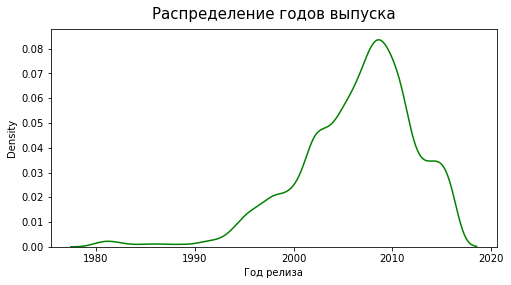

In [31]:
plt.figure(figsize=(8,4))

sns.distplot(data['year_of_release'], color='green', hist=False)

plt.xlabel('Год релиза')
plt.title('Распределение годов выпуска',size=15, y=(1.02));

In [32]:
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Для меня шутер и экшн одно и то же. Но, видимо, не здесь. Ок

In [33]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [34]:
data['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.5       2
1.9       2
0.7       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Присутствует значение **tbd**. В задании упоминалось, что есть такие значения. Это значит **to be done**. Я так понимаю, что это значит **"еще не оценено"**. А если нет оценки, то я бы заменил на NaN

In [35]:
data['user_score'] = data['user_score'].where(data['user_score'] != 'tbd', np.nan)

In [36]:
data['user_score'] = data['user_score'].astype('float64')

### Расчет суммарных продаж

In [37]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [38]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


### Выводы

В первом пункте были решены следующие задачи:

    - переименовали столбцы
    - избавились от пропусков в столбце year_of_release:
        - нашли одноименные игры, но на других платформах и записали в пропуски год
        - с помощью регулярного выражения нашли в названии игры год
        - оставшиеся пропуски заменили на медианы по платформам
    - изменили тип данных столбца year_of_release с object на int и столбца user_score на float64
    - изучили столбцы на предмет дубликатов
    - добавили столбец total_sales

## Исследовательский анализ данных

### Количество игр по годам

Посмотрим, сколько игр выпускалось в разные годы

In [39]:
data['year_of_release'].value_counts()

2009    1446
2008    1437
2010    1271
2007    1199
2011    1159
2006    1046
2005     955
2002     837
2004     799
2003     786
2012     654
2015     606
2014     581
2013     548
2016     502
2001     488
2000     393
1998     379
1999     340
1997     289
1996     264
1995     219
1994     128
1993      60
1981      46
1992      43
1991      41
1982      36
1980      26
1986      21
1985      18
1983      17
1989      17
1987      16
1988      16
1990      16
1984      14
Name: year_of_release, dtype: int64

### Количество платформ по продажам

In [40]:
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


In [41]:
top_platofrms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()['platform'].head(18)

In [42]:
top_platofrms

0      PS2
1     X360
2      PS3
3      Wii
4       DS
5       PS
6      GBA
7      PS4
8      PSP
9       PC
10     3DS
11      XB
12      GB
13     NES
14     N64
15    SNES
16      GC
17    XOne
Name: platform, dtype: object

Почему я взял 18 - очень хотелось, чтобы попал XOne =) Она современная

Построим распределния по годам:

Напишем функцию:

In [43]:
def distribution(dataset, platforms):
    global mean_life
    mean_life = [] # создадим список средней жизни платформы    
    for platform in platforms:
        print('Платформа:', platform)
        mean_life_platform = data.query('platform == @platform')['year_of_release'].max() - data.query('platform == @platform')['year_of_release'].min()
        mean_life.append(mean_life_platform)
        print('Время жизни:', mean_life_platform)
        sns.catplot(
            x="year_of_release", 
            y="total_sales", kind="bar", 
            data = dataset.query('platform == @platform'
            ) \
            .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum') \
            .reset_index())
        plt.title('Распределние проданных копий по годам')
        plt.xlabel('Год')
        plt.ylabel('Количество')
        plt.show()
    return

Платформа: PS2
Время жизни: 11


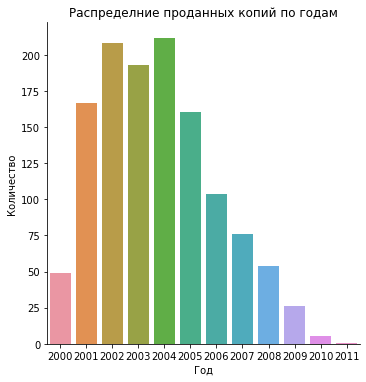

Платформа: X360
Время жизни: 11


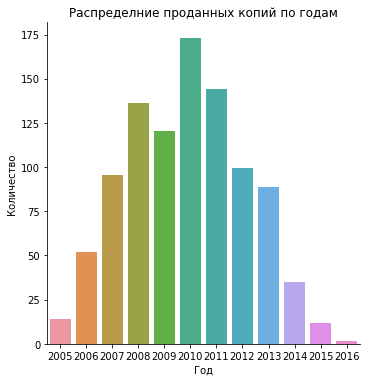

Платформа: PS3
Время жизни: 10


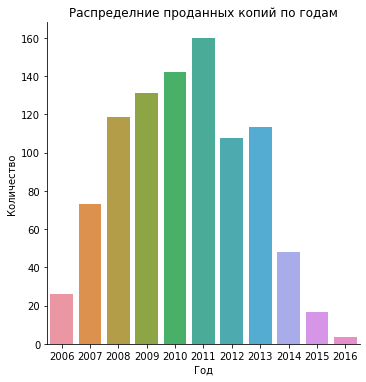

Платформа: Wii
Время жизни: 10


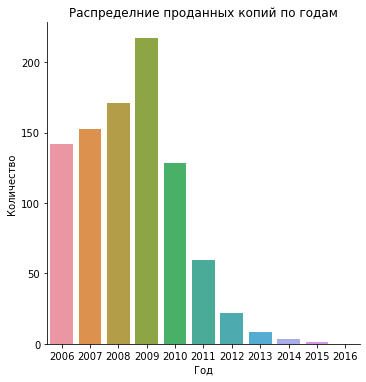

Платформа: DS
Время жизни: 9


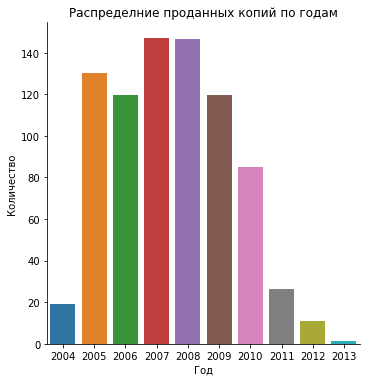

Платформа: PS
Время жизни: 9


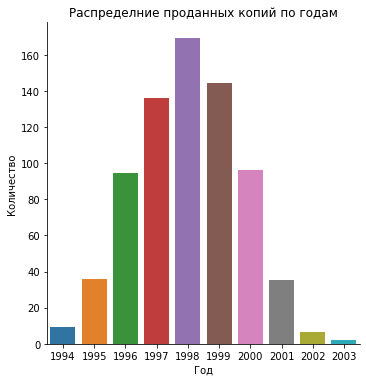

Платформа: GBA
Время жизни: 7


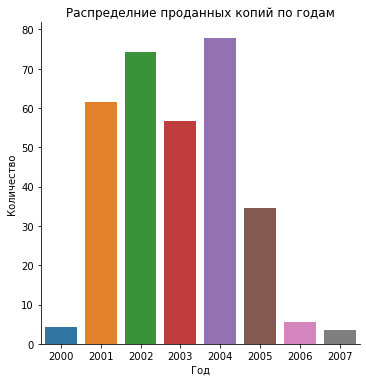

Платформа: PS4
Время жизни: 3


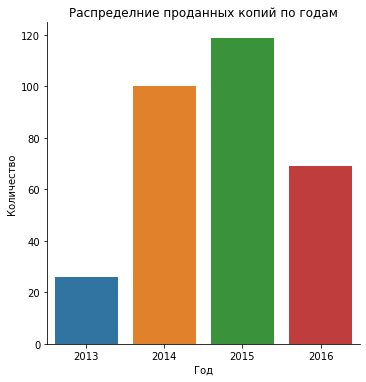

Платформа: PSP
Время жизни: 11


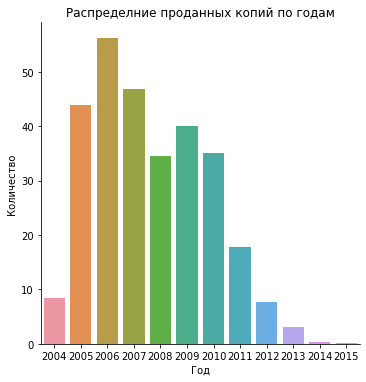

Платформа: PC
Время жизни: 31


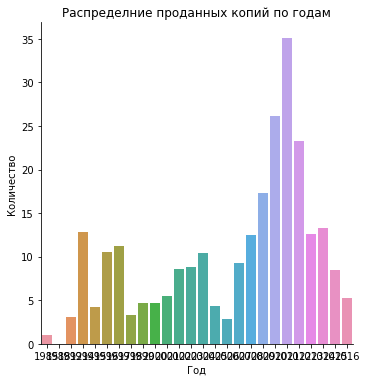

Платформа: 3DS
Время жизни: 5


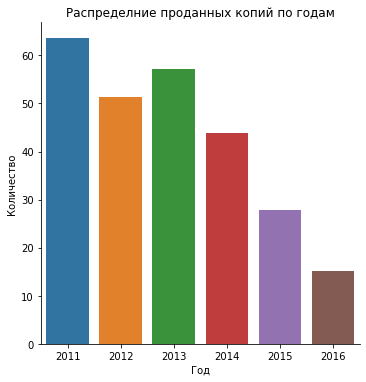

Платформа: XB
Время жизни: 8


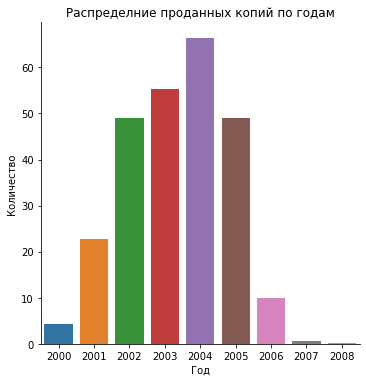

Платформа: GB
Время жизни: 13


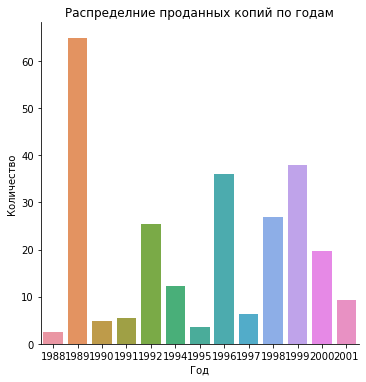

Платформа: NES
Время жизни: 11


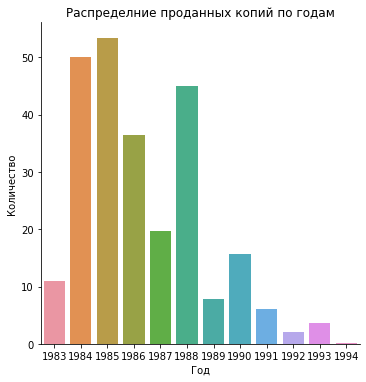

Платформа: N64
Время жизни: 6


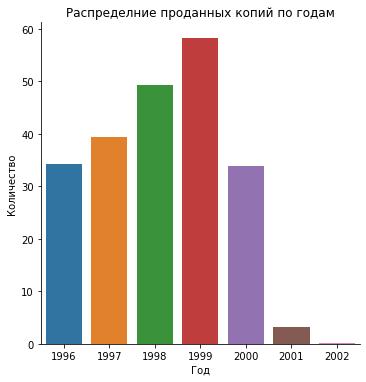

Платформа: SNES
Время жизни: 9


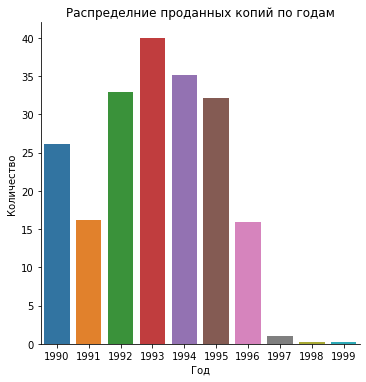

Платформа: GC
Время жизни: 6


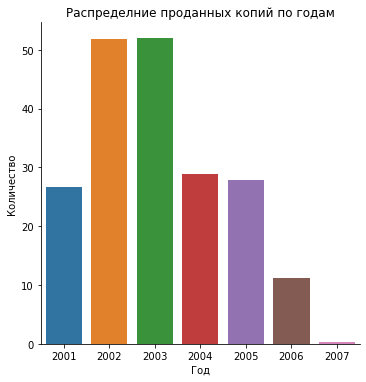

Платформа: XOne
Время жизни: 3


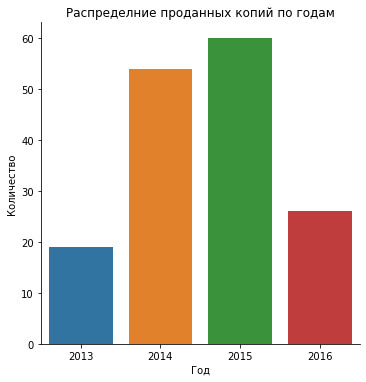

In [44]:
distribution(data, top_platofrms)

Найдем среднее время жизни:

In [45]:
np.median(mean_life)

9.0

Почти все платформы "живут" в среднем 9 лет. Кто-то чуть больше, кто-то чуть меньше. Графики очень сильно напоминат нормальное распределение. В данном случае платформа сначала "рождается", через пару лет приходит пик популярности, а затем она "умирает", когда игр на нее все меньше и меньше. На смену приходит следующее поколение консолей. Исключением является только ПК - он не умер через 10 лет, а продолжал развиваться. Но тем не менее, у него тоже есть пиковое значение в последние 10 лет, а затем идет спад. 

Однако, 9 лет - это время от рождения платформы до прекращения ее поддержки. Выход консолей следующего поколения приходится на спад продаж (например, XB и XB360 - спад у XB приходится на 2006, а выход новой консоли - XB360 - так же случился в 2006 году). Поэтому я бы не стал брать актуальный период, равным 9 годам. В расчет возьмем период от выхода консоли до спада продаж. 

**Таким образом, *актуальный период* примем равным 6 лет**

In [46]:
data_actual = data.query('year_of_release >= 2010')

In [47]:
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5321 entries, 14 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5321 non-null   object 
 1   platform         5321 non-null   object 
 2   year_of_release  5321 non-null   int64  
 3   genre            5321 non-null   object 
 4   na_sales         5321 non-null   float64
 5   eu_sales         5321 non-null   float64
 6   jp_sales         5321 non-null   float64
 7   other_sales      5321 non-null   float64
 8   critic_score     2340 non-null   float64
 9   user_score       2527 non-null   float64
 10  rating           3145 non-null   object 
 11  total_sales      5321 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 540.4+ KB


### Работа с актуальными данными

#### Анализ платформ по продажам

Посмотрим на лидеров рынка

In [48]:
data_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS3,591.11
X360,553.92
PS4,314.14
3DS,259.00
Wii,223.74
XOne,159.32
PC,124.23
DS,123.80
WiiU,82.19


In [49]:
top_platofrms_actual = data_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum') \
                                    .sort_values(by='total_sales', ascending=False) \
                                    .reset_index()['platform'].head(11)
# Вообще их 12, но 12-я по продажам - это PS2, она уже не актуальна

In [50]:
top_platofrms_actual

0      PS3
1     X360
2      PS4
3      3DS
4      Wii
5     XOne
6       PC
7       DS
8     WiiU
9      PSP
10     PSV
Name: platform, dtype: object

Платформа: PS3
Время жизни: 10


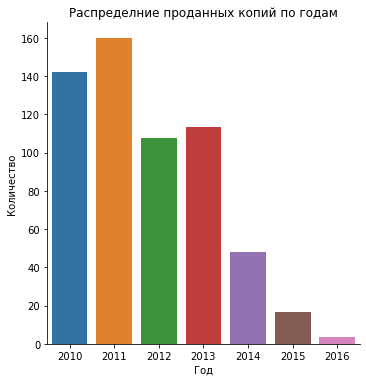

Платформа: X360
Время жизни: 11


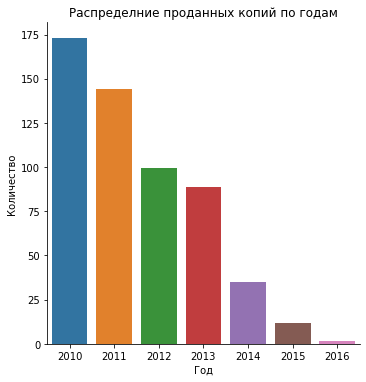

Платформа: PS4
Время жизни: 3


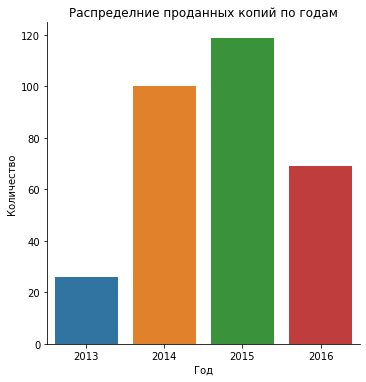

Платформа: 3DS
Время жизни: 5


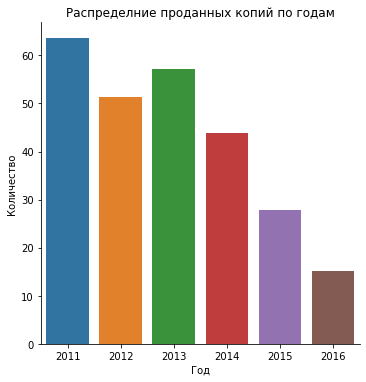

Платформа: Wii
Время жизни: 10


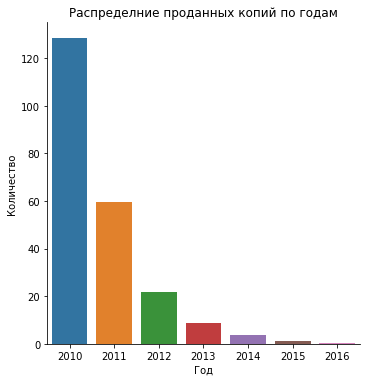

Платформа: XOne
Время жизни: 3


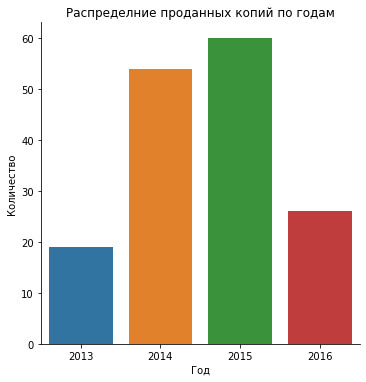

Платформа: PC
Время жизни: 31


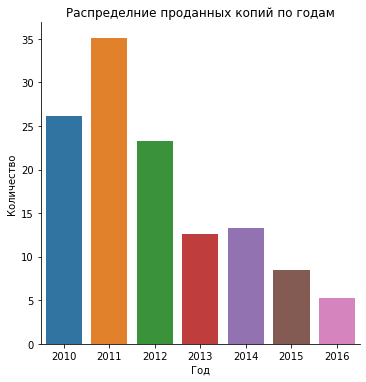

Платформа: DS
Время жизни: 9


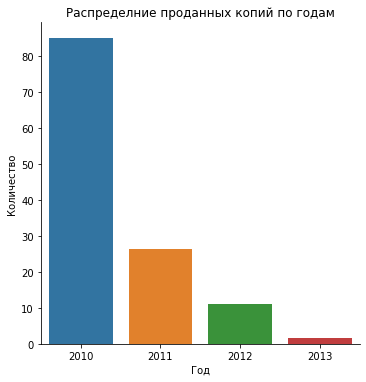

Платформа: WiiU
Время жизни: 4


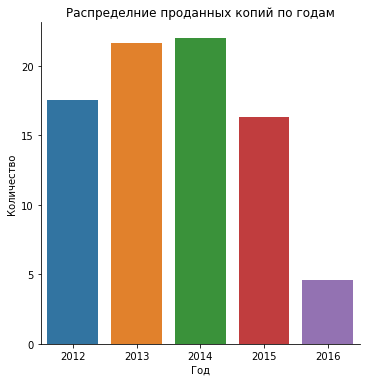

Платформа: PSP
Время жизни: 11


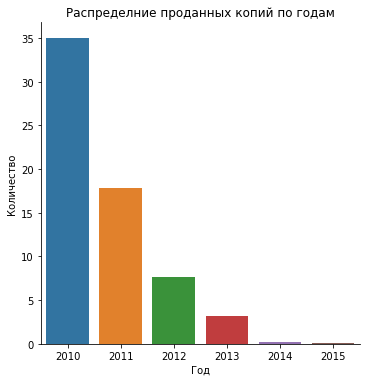

Платформа: PSV
Время жизни: 5


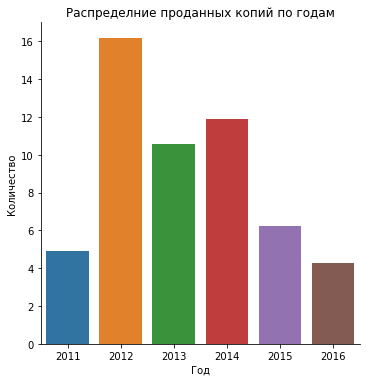

In [51]:
distribution(data_actual, top_platofrms_actual)

    Что можно сказать по графикам:
        - платформы PS3, XBox360, PSP, DS,  Wii теряют продажи. Знаю точно, что PS3, PS2, PSP и DS уже не поддерживаются. Поэтому работать с ними нет никакой необходимости, они заранее неприбыльны;
        - оставим платформы: PS4, XOne, PSV, 3DS, PC, WiiU. При этом ни одна не показывает роста. Кризис игровой индустрии? Тем не менее, продажи идут и идут неплохо


#### Ящики с усами

Построим boxplot'ы в разбивке по платформам:

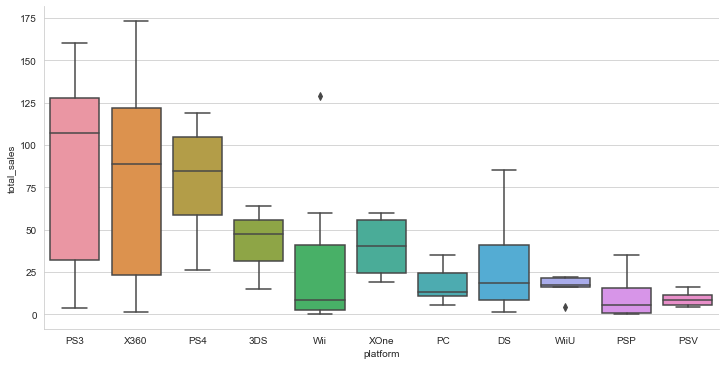

In [52]:
sns.set_style('whitegrid')
sns.catplot(
    x="platform", 
    y="total_sales", 
    kind="box",
    data = data_actual.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum').reset_index(),
    order=top_platofrms_actual,
    height=5, aspect=2
)

    Итак, что мы видим (по порядку):
        - PS3 - огромное количество продаж, график скошен влево, медиана в районе 105 млн копий в год
        - Х360 - примерно то же самое, что у PS3, Но с меньшей медианой и более ровным распределением
        - PS4 - относительно новая платформа, медиана продаж в районе 80 млн, распределние почти нормальное, есть небольшой скос влево
        - 3DS - менее успешная платформа, чем три предыдущие, медиана в районе 50, график скошен влево
        - Wii - очень сильно график скошен вправо, медиана в районе 10 млн
        - XOne - как и PS4, это новая платформа. Имеем нормальное распределние продаж
        - PC - рынок раза в 4 меньше, чем у PS3, график скошен вправо


#### Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы

Для первичного исследования возьмем ПК

Text(0, 0.5, 'Продажи')

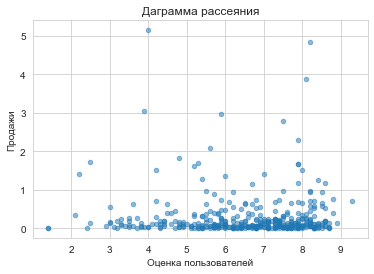

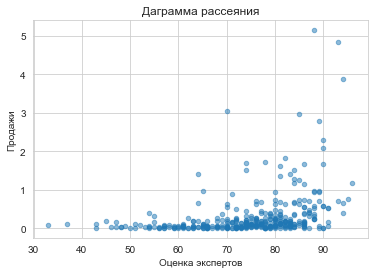

In [53]:
data_actual.query('platform == "PC"').plot(x='user_score', y='total_sales', grid=True, kind='scatter', alpha=0.5)
plt.title('Даграмма рассеяния')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
data_actual.query('platform == "PC"').plot(x='critic_score', y='total_sales', grid=True, kind='scatter', alpha=0.5)
plt.title('Даграмма рассеяния')
plt.xlabel('Оценка экспертов')
plt.ylabel('Продажи')

Сложно что-то сказать по этим графикам. Поэтому я предлагаю следующее: 

    - разобьем оценки экспертов и игроков на категории: плохо, средне, хорошо, отлично
    - сгруппируем по платформам и оценкам и найдем медианы продаж

Тогда мы получим более наглядный график

Функция для категоризации:

In [54]:
def score_critic(row):
    if row['critic_score'] <= 50:
        row['critic_score_cat'] = 2
    if 50 < row['critic_score'] <= 70:  
        row['critic_score_cat'] = 3
    if 70 < row['critic_score'] <= 85:  
        row['critic_score_cat'] = 4
    if 85 < row['critic_score'] <= 100:  
        row['critic_score_cat'] = 5    
    return row    

In [55]:
data_actual_up = data.copy()

In [56]:
data_actual_up = data_actual.apply(score_critic, axis=1)

<AxesSubplot:xlabel='critic_score_cat'>

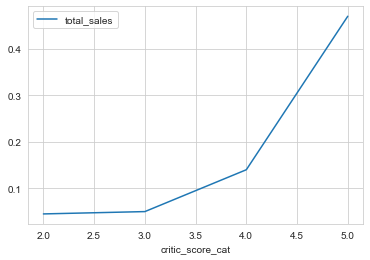

In [57]:
data_actual_up.query('platform =="PC"') \
                .pivot_table(index='critic_score_cat', values='total_sales', aggfunc='median') \
                .reset_index() \
                .sort_values(by='critic_score_cat') \
                .plot(x='critic_score_cat', y='total_sales', grid=True, kind='line')

Посчитаем корреляцию:

In [58]:
print(data_actual_up.query('platform == "PC"')['total_sales'].corr(data_actual_up['critic_score_cat']))

0.31675262560624884


Присутствует линейная связь между оценками критиков и продажами, но не очень сильная, судя по коэффициенту корреляции

Сделаем то же самое для оценок пользователей:

In [59]:
def score_user(row):
    if row['user_score'] <= 5:
        row['user_score_cat'] = 2
    if 5 < row['user_score'] <= 7:  
        row['user_score_cat'] = 3
    if 7 < row['user_score'] <= 8.5:  
        row['user_score_cat'] = 4
    if 8.5 < row['user_score'] <= 10:  
        row['user_score_cat'] = 5    
    return row    

In [60]:
data_actual_up = data_actual_up.apply(score_user, axis=1)

<AxesSubplot:xlabel='user_score_cat'>

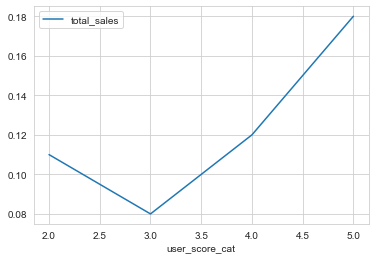

In [61]:
data_actual_up.query('platform =="PC"') \
                .pivot_table(index='user_score_cat', values='total_sales', aggfunc='median') \
                .reset_index() \
                .sort_values(by='user_score_cat') \
                .plot(x='user_score_cat', y='total_sales', grid=True, kind='line')

Посчитаем корреляцию:

Продажи от оценок пользователей:

In [62]:
print(data_actual_up.query('platform == "PC"')['total_sales'].corr(data_actual_up['user_score_cat']))

-0.0163233258586627


Здесь зависимость нелинейная. Игры с плохими оценками продаются хуже, чем со средними, а дальше идет по нарастающей

#### Влияние отзывов на продажи по всем платформам

Платформа: PS3


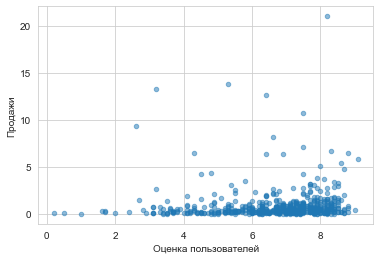

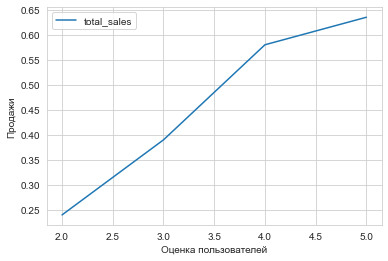

Связь продаж от оценок пользователей 0.07021846401783029


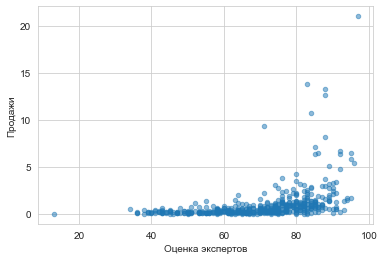

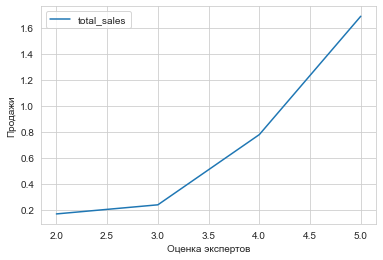

Связь продаж от оценок экспертов 0.4001703065657033
Платформа: X360


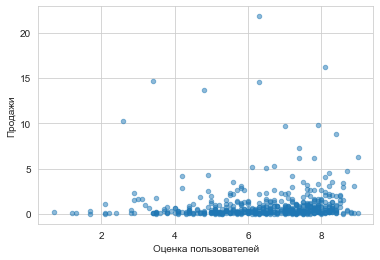

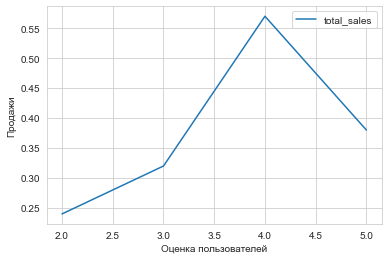

Связь продаж от оценок пользователей 0.049733712384207714


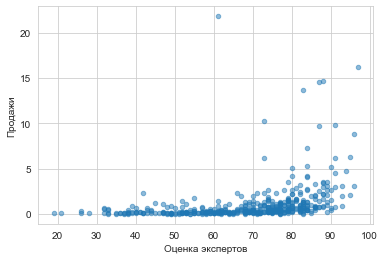

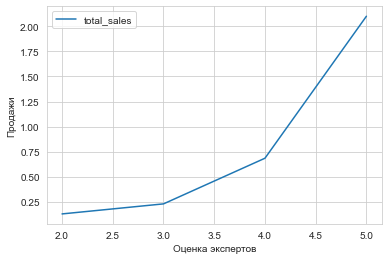

Связь продаж от оценок экспертов 0.3576969987129913
Платформа: PS4


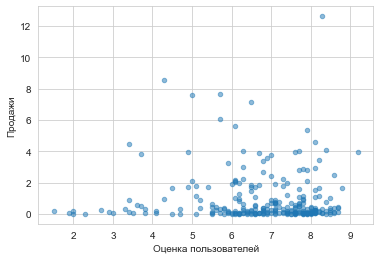

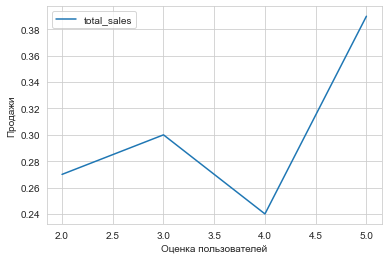

Связь продаж от оценок пользователей -0.09058088531696394


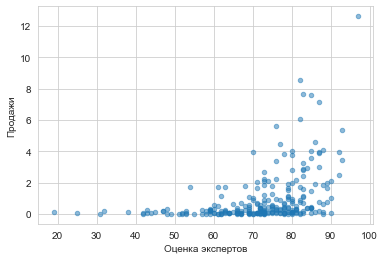

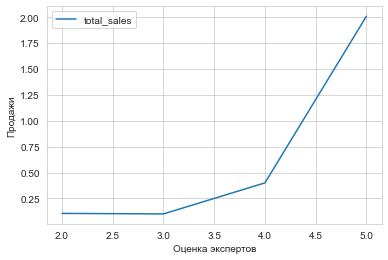

Связь продаж от оценок экспертов 0.3878684095504839
Платформа: 3DS


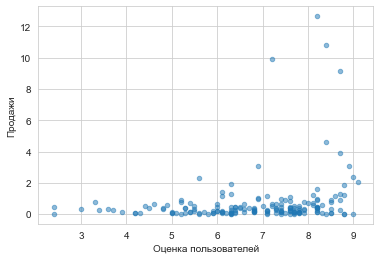

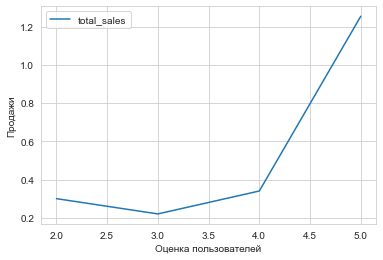

Связь продаж от оценок пользователей 0.2285241476077537


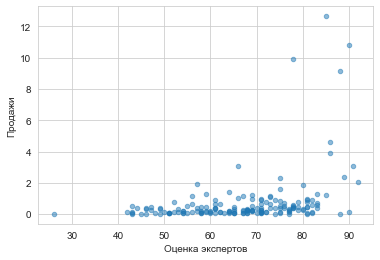

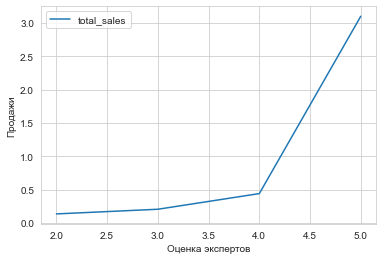

Связь продаж от оценок экспертов 0.3591664870116852
Платформа: Wii


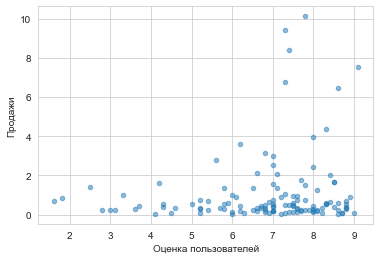

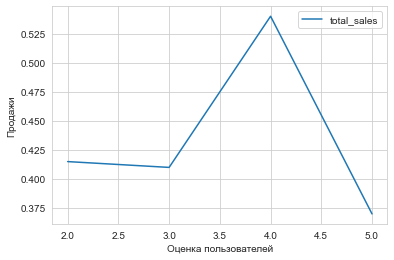

Связь продаж от оценок пользователей 0.17463682496149402


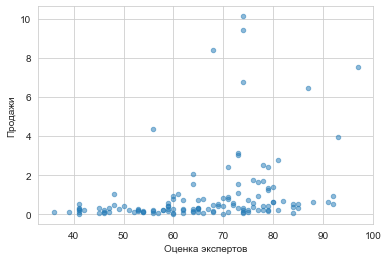

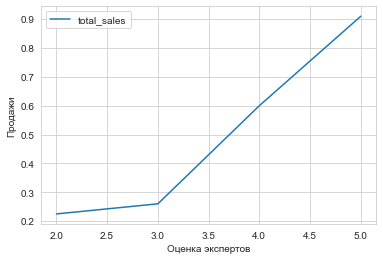

Связь продаж от оценок экспертов 0.3367050011688369
Платформа: XOne


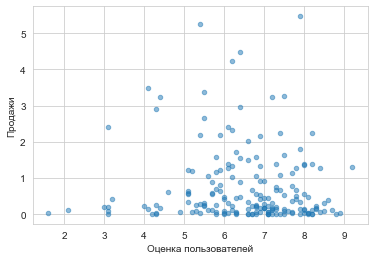

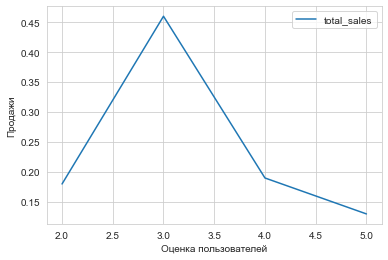

Связь продаж от оценок пользователей -0.08671920118548714


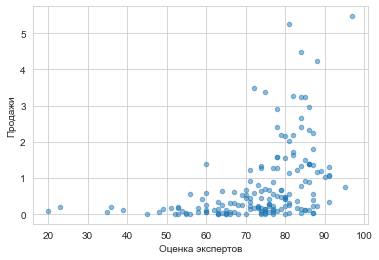

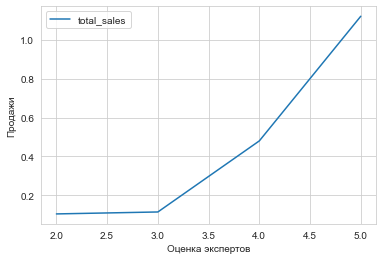

Связь продаж от оценок экспертов 0.38522774455851483
Платформа: PC


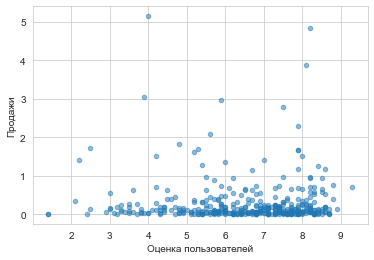

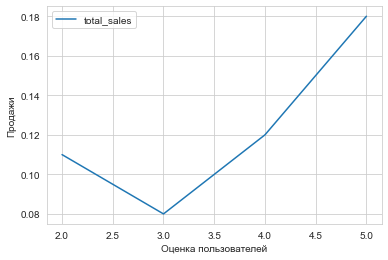

Связь продаж от оценок пользователей -0.0163233258586627


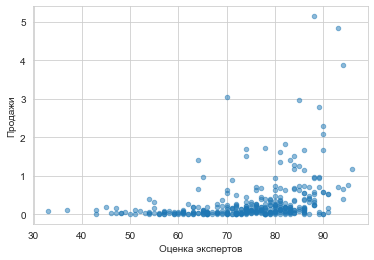

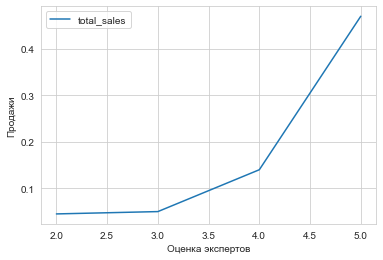

Связь продаж от оценок экспертов 0.31675262560624884
Платформа: DS


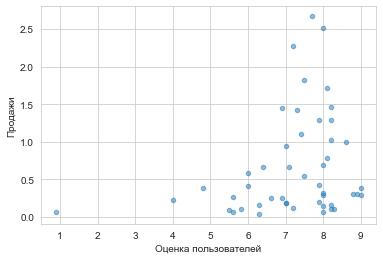

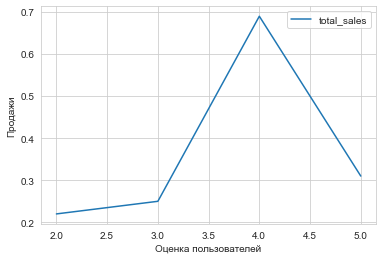

Связь продаж от оценок пользователей 0.24558156959446834


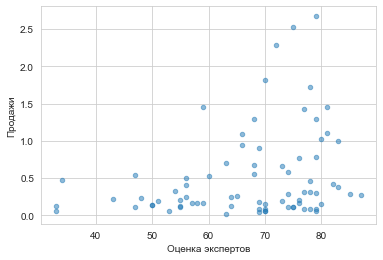

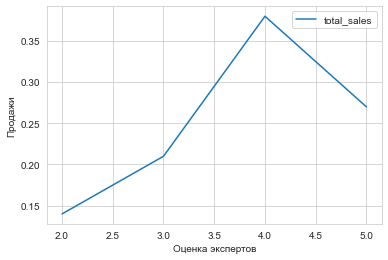

Связь продаж от оценок экспертов 0.2658181264745938
Платформа: WiiU


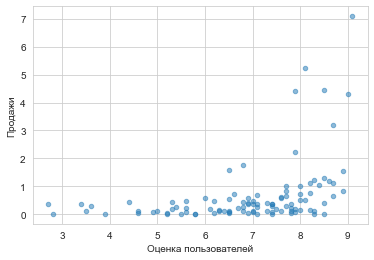

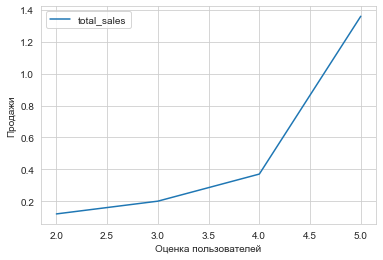

Связь продаж от оценок пользователей 0.4205818087983072


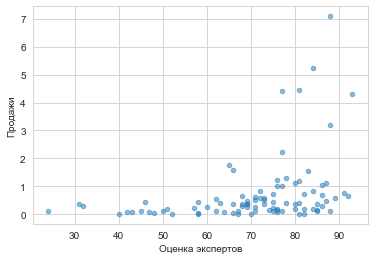

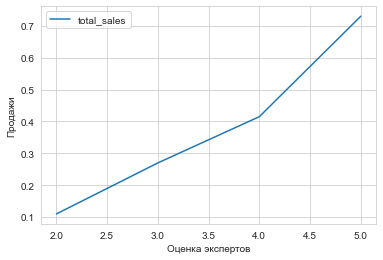

Связь продаж от оценок экспертов 0.35899761942212854
Платформа: PSP


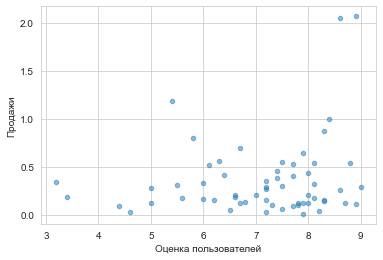

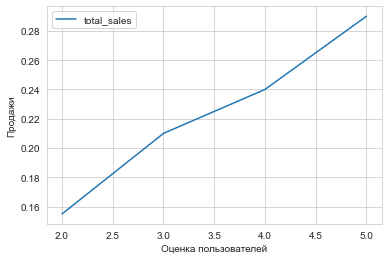

Связь продаж от оценок пользователей 0.25856869131797666


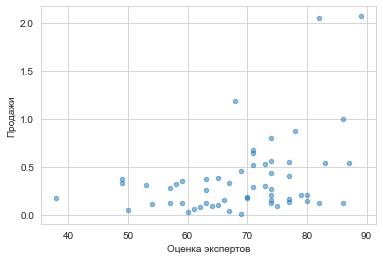

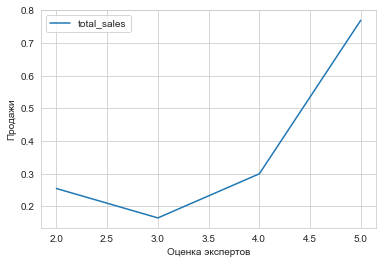

Связь продаж от оценок экспертов 0.397613441448763
Платформа: PSV


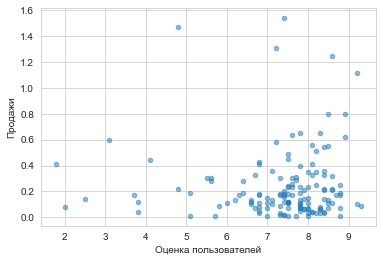

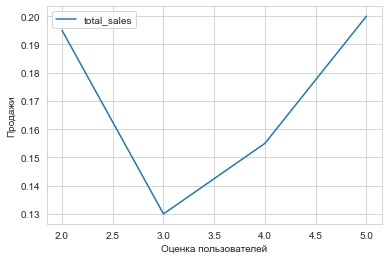

Связь продаж от оценок пользователей 0.058951491876687315


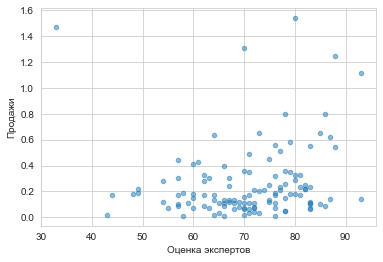

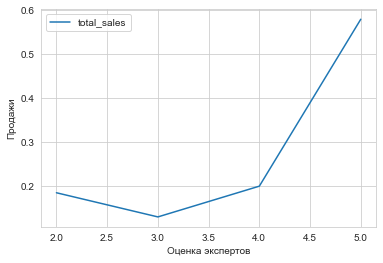

Связь продаж от оценок экспертов 0.1866748098714706


In [63]:
for platform in top_platofrms_actual:
    print('Платформа:', platform)
    # строим диаграмму рассеяния
    data_actual_up.query('platform == @platform') \
    .plot(x='user_score', y='total_sales', grid=True, kind='scatter', alpha=0.5)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.show()
    # строим зависимость от категории оценки игроков
    data_actual_up.query('platform == @platform') \
                .pivot_table(index='user_score_cat', values='total_sales', aggfunc='median') \
                .reset_index() \
                .sort_values(by='user_score_cat') \
                .plot(x='user_score_cat', y='total_sales', grid=True, kind='line')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.show()
    print('Связь продаж от оценок пользователей', data_actual_up.query('platform == @platform')['total_sales'] \
                                                                  .corr(data_actual_up['user_score_cat']))
    # строим диаграмму рассеяния
    data_actual_up.query('platform == @platform') \
                    .plot(x='critic_score', y='total_sales', grid=True, kind='scatter', alpha=0.5)
    plt.xlabel('Оценка экспертов')
    plt.ylabel('Продажи')
    plt.show()
    # строим зависимость от категории оценки экспертов
    data_actual_up.query('platform == @platform') \
                .pivot_table(index='critic_score_cat', values='total_sales', aggfunc='median') \
                .reset_index() \
                .sort_values(by='critic_score_cat') \
                .plot(x='critic_score_cat', y='total_sales', grid=True, kind='line')
    plt.xlabel('Оценка экспертов')
    plt.ylabel('Продажи')    
    plt.show()
    print('Связь продаж от оценок экспертов', data_actual_up.query('platform == @platform')['total_sales'] \
                                                              .corr(data_actual_up['critic_score_cat']))

Из серии "сколько людей - столько и мнений". Связи продаж и оценок пользователей нет, в некоторых платформах (PS4 и XOne) корреляция отрицательная и игры с плохими оценками продаются лучше, чем со средними. Или, как в платформе DS, игры с хорошими продаются лучше, чем с плохими.

Поэтому я бы не сказал, что оценки пользователей и экспертов влияют на продажи. Например, игра может быть культовой или продолжением успешной серии, у нее большие продажи, а сама игра получилось не очень, в следствие чего и оценки она получила плохие.

Посмотрим на матрицу корреляции:

In [64]:
print(data_actual[['critic_score', 'user_score', 'total_sales']].corr()) # матрица корреляции

              critic_score  user_score  total_sales
critic_score      1.000000    0.548640     0.316736
user_score        0.548640    1.000000     0.055025
total_sales       0.316736    0.055025     1.000000


И визуализируем ее:

<AxesSubplot:>

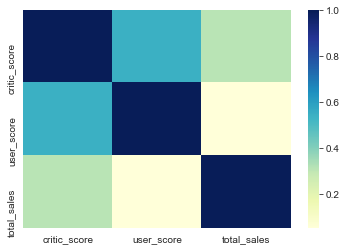

In [65]:
sns.heatmap(data_actual[['critic_score', 'user_score', 'total_sales']].corr(), cmap="YlGnBu") 

#### Найдем самые прибыльные жанры

In [66]:
data_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum').reset_index().sort_values(by='total_sales', ascending=False)

,genre,total_sales
0,Action,677.78
8,Shooter,482.79
10,Sports,329.45
7,Role-Playing,315.62
3,Misc,235.05
6,Racing,123.08
4,Platform,119.72
2,Fighting,81.59
9,Simulation,72.24
1,Adventure,61.09


Диаграмма:

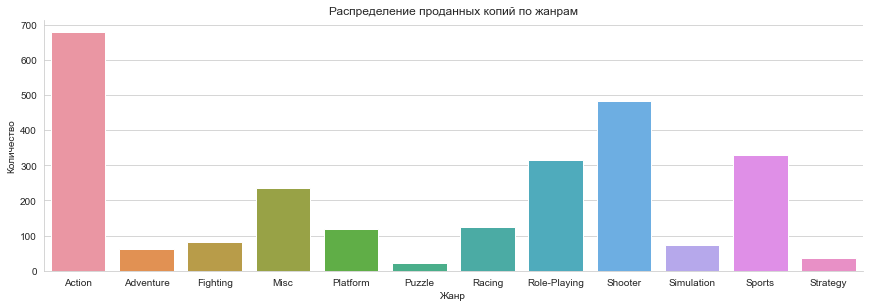

In [67]:
sns.catplot(
        x="genre", 
        y="total_sales", kind="bar", 
        data = data_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum') \
    .reset_index(),
    height=4, aspect=3)
plt.title('Распределение проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.show()

Самыми прибыльными жанрами являются Action и Shooter. А вот любителей стратегий и пазлов меньше в 20 раз

А теперь посмотрим на средние значения продаж. Почему на средние? Потому что эта метрика более устойчива к выбросам, чем просто суммы и количественные признаки

In [68]:
data_actual.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False).reset_index()

,genre,total_sales
0,Shooter,0.380
1,Platform,0.210
2,Sports,0.200
3,Fighting,0.180
4,Racing,0.165
5,Role-Playing,0.150
6,Action,0.140
7,Misc,0.130
8,Simulation,0.100
9,Strategy,0.080


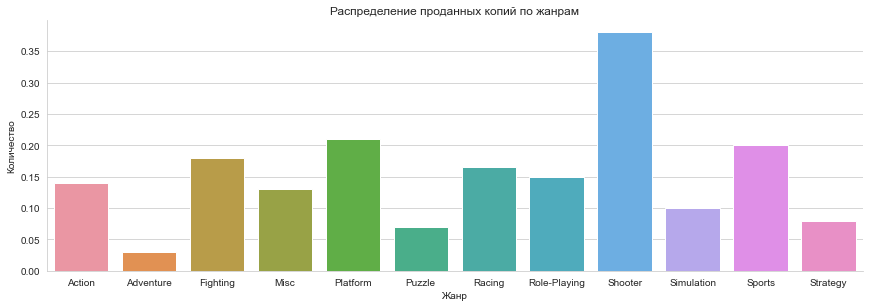

In [69]:
sns.catplot(
        x="genre", 
        y="total_sales", kind="bar", 
        data = data_actual.pivot_table(index='genre', values='total_sales', aggfunc='median') \
    .reset_index(),
    height=4, aspect=3)
plt.title('Распределение проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.show()

Видимо, экшенов просто больше чем всех остальных, поэтому такие большие продажи

In [70]:
len(data_actual.query('genre == "Action"'))

1507

In [71]:
len(data_actual.query('genre == "Shooter"'))

419

In [72]:
data_actual.query('genre == "Shooter"')['total_sales'].max()

14.73

## Портерт покупателя каждого региона

### Заполнение пропусков в рейтинге

In [73]:
def rating(row):
    if pd.isna(row['rating']):
        genre = row['genre']
        row['rating'] = np.argmax(data_actual.query('genre == @genre')['rating'].value_counts())
    return row

In [74]:
data_actual = data_actual.apply(rating, axis=1)

### Регион NA

#### Платформа

In [75]:
data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,platform,na_sales
0,X360,336.16
1,PS3,230.72
2,Wii,121.93
3,PS4,108.74
4,XOne,93.12


Граждане северной Америки консольщики. Предыдущее поколение консолей опережает по продажам актуальное поколение из-за того, что актуальные консоли только недавно вышли на рынок

Давай посмотрим на медианы теперь

In [76]:
data_actual.pivot_table(index='platform', values='na_sales', aggfunc='median') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,platform,na_sales
0,X360,0.15
1,XOne,0.12
2,Wii,0.11
3,WiiU,0.11
4,PS3,0.09


Плюс-минус то же самое. Ушла PS4, но это скорее всего из-за новизны

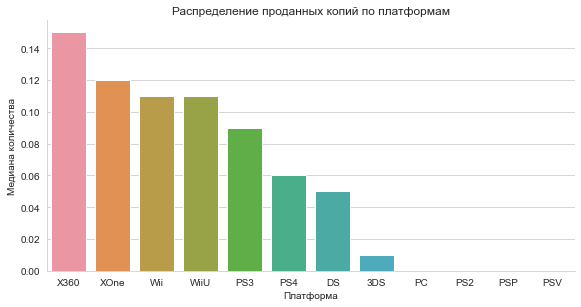

In [77]:
sns.catplot(
        x="platform", 
        y="na_sales", kind="bar", 
        data = data_actual.pivot_table(index='platform', values='na_sales', aggfunc='median') \
                            .sort_values(by='na_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по платформам')
plt.xlabel('Платформа')
plt.ylabel('Медиана количества')
plt.show()

#### Жанр

In [78]:
data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,genre,na_sales
0,Action,292.88
1,Shooter,238.77
2,Sports,157.49
3,Misc,124.17
4,Role-Playing,112.16


Ну как-то так. Как на приставке с джойстиком можно играть в шутеры я не очень представляю

In [79]:
data_actual.pivot_table(index='genre', values='na_sales', aggfunc='median') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,genre,na_sales
0,Shooter,0.17
1,Platform,0.10
2,Sports,0.09
3,Fighting,0.07
4,Racing,0.07


Здесь медиана и сумма уже отличаются 

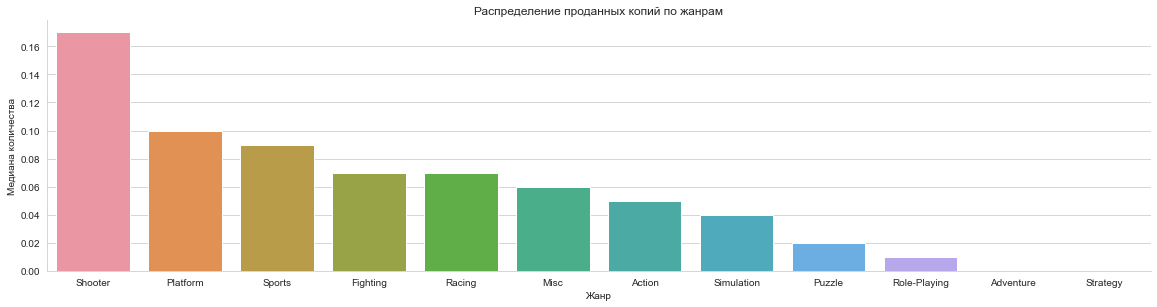

In [80]:
sns.catplot(
        x="genre", 
        y="na_sales", kind="bar", 
        data = data_actual.pivot_table(index='genre', values='na_sales', aggfunc='median') \
                            .sort_values(by='na_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=4)
plt.title('Распределение проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Медиана количества')
plt.show()

#### Рейтинг

In [81]:
data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,rating,na_sales
0,M,384.40
1,E,272.21
2,T,161.75
3,E10+,160.51
4,0,156.28


Чаще всего покупается рейтинг M - для взрослых

In [82]:
data_actual.pivot_table(index='rating', values='na_sales', aggfunc='median') \
            .sort_values(by='na_sales', ascending=False) \
            .reset_index() \
            .head(5)

,rating,na_sales
0,EC,0.27
1,M,0.17
2,E10+,0.12
3,E,0.09
4,T,0.09


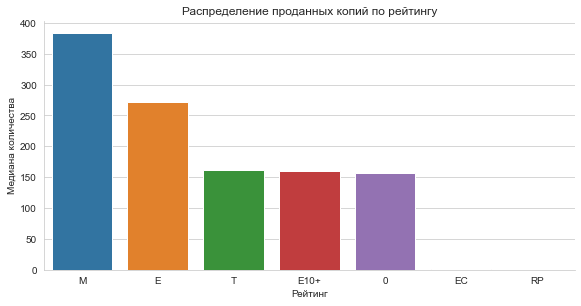

In [83]:
sns.catplot(
        x="rating", 
        y="na_sales", kind="bar", 
        data = data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum') \
                            .sort_values(by='na_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Медиана количества')
plt.show()

### Регион EU

Заменю везде сумму на медиану

#### Платформа

In [84]:
data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='median') \
            .sort_values(by='eu_sales', ascending=False) \
            .reset_index() \
            .head(5)

,platform,eu_sales
0,PS4,0.08
1,X360,0.08
2,WiiU,0.07
3,XOne,0.07
4,PC,0.05


Европейцы предпочитают ПК и консоли нового поколения

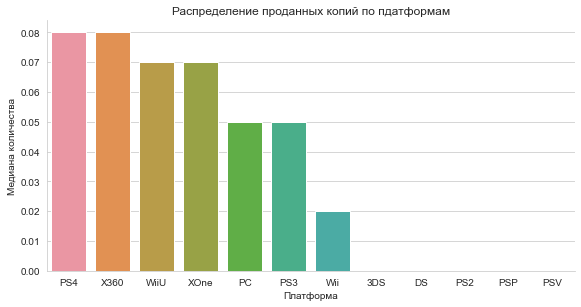

In [85]:
sns.catplot(
        x="platform", 
        y="eu_sales", kind="bar", 
        data = data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='median') \
                            .sort_values(by='eu_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по пдатформам')
plt.xlabel('Платформа')
plt.ylabel('Медиана количества')
plt.show()

#### Жанр

In [86]:
data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='median') \
            .sort_values(by='eu_sales', ascending=False) \
            .reset_index() \
            .head(5)

,genre,eu_sales
0,Shooter,0.15
1,Platform,0.08
2,Racing,0.06
3,Sports,0.04
4,Action,0.03


По жанрам те же самые предпочтения, что у жителей Северной Америки. Меньше любят fighting

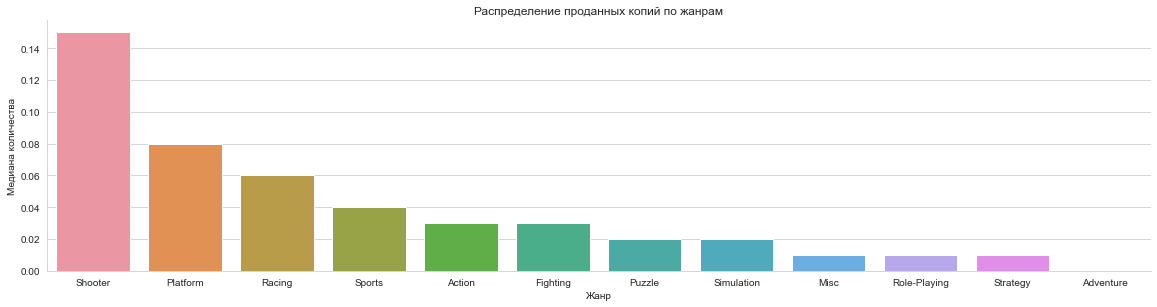

In [87]:
sns.catplot(
        x="genre", 
        y="eu_sales", kind="bar", 
        data = data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='median') \
                            .sort_values(by='eu_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=4)
plt.title('Распределение проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Медиана количества')
plt.show()

#### Рейтинг

In [88]:
data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum') \
            .sort_values(by='eu_sales', ascending=False) \
            .reset_index() \
            .head(5)

,rating,eu_sales
0,M,294.25
1,E,197.61
2,0,139.65
3,T,113.32
4,E10+,100.35


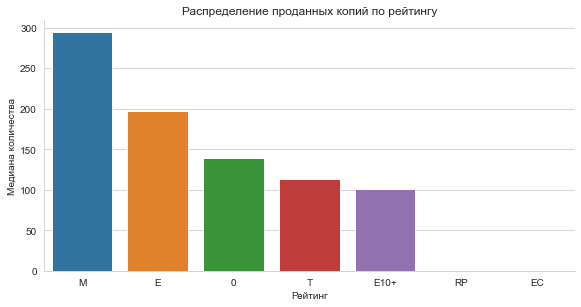

In [89]:
sns.catplot(
        x="rating", 
        y="eu_sales", kind="bar", 
        data = data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum') \
                            .sort_values(by='eu_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Медиана количества')
plt.show()

Аналогично Америке - чаще всего для взрослых

### Регион JP

#### Платформа

In [90]:
data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum') \
            .sort_values(by='jp_sales', ascending=False) \
            .reset_index() \
            .head(5)

,platform,jp_sales
0,3DS,100.67
1,PS3,59.37
2,PSP,42.20
3,DS,27.90
4,PSV,21.91


In [91]:
data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='median') \
            .sort_values(by='jp_sales', ascending=False) \
            .reset_index() \
            .head(5)

,platform,jp_sales
0,3DS,0.05
1,PSP,0.03
2,PSV,0.03
3,PS3,0.02
4,PS2,0.01


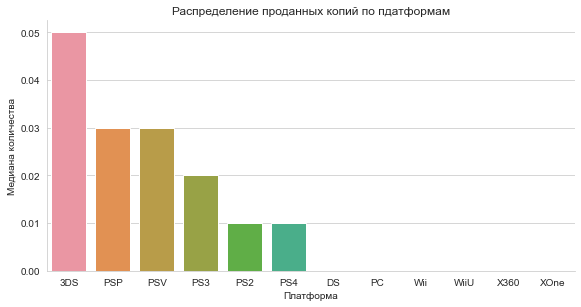

In [92]:
sns.catplot(
        x="platform", 
        y="jp_sales", kind="bar", 
        data = data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='median') \
                            .sort_values(by='jp_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по пдатформам')
plt.xlabel('Платформа')
plt.ylabel('Медиана количества')
plt.show()

У азиатов совершенно другие предпочтения. Если еврпоейцы и американцы предпочитают полноценные приставки и ПК, то азиаты предпочитают карманные приствки. Консоли PS2 и PS3 в меньшей степени 

#### Жанр

In [93]:
data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum') \
            .sort_values(by='jp_sales', ascending=False) \
            .reset_index() \
            .head(5)

,genre,jp_sales
0,Role-Playing,103.69
1,Action,72.21
2,Misc,24.30
3,Platform,15.81
4,Adventure,15.67


И по жанрам различия с европейцами и американцами. Больше всего любят РПГ и экшены, потом идет провал в продажах в 3 раза и следуют "разное", "платформеры" и "приключения"

In [94]:
data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='median') \
            .sort_values(by='jp_sales', ascending=False) \
            .reset_index() \
            .head(5)

,genre,jp_sales
0,Role-Playing,0.06
1,Adventure,0.02
2,Fighting,0.02
3,Action,0.00
4,Misc,0.00


Почти то же самое, что и по сумме. Не хватает экшенов

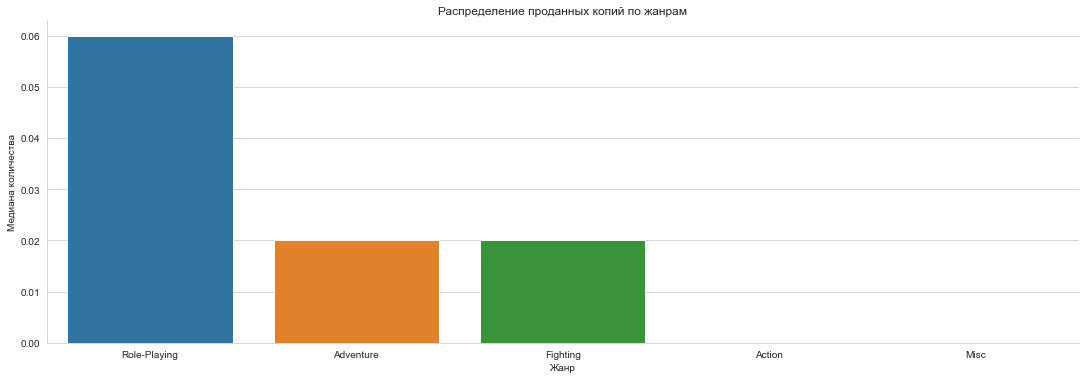

In [95]:
sns.catplot(
        x="genre", 
        y="jp_sales", kind="bar", 
        data = data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='median') \
                            .sort_values(by='jp_sales', ascending=False) \
                            .reset_index() \
                            .head(5),
    height=5, aspect=3)
plt.title('Распределение проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Медиана количества')
plt.show()

#### Рейтинг

In [96]:
data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum') \
            .sort_values(by='jp_sales', ascending=False) \
            .reset_index() \
            .head(5)

,rating,jp_sales
0,0,171.61
1,E,47.87
2,T,42.21
3,M,30.48
4,E10+,13.22


А здесь в основном играют подростки

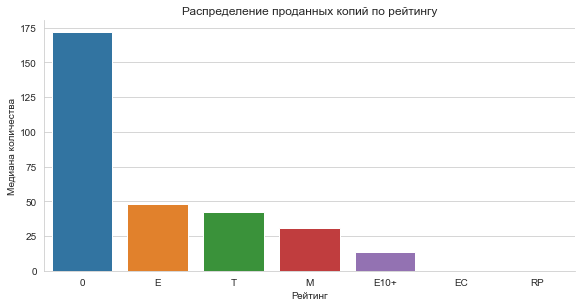

In [97]:
sns.catplot(
        x="rating", 
        y="jp_sales", kind="bar", 
        data = data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum') \
                            .sort_values(by='jp_sales', ascending=False) \
                            .reset_index(),
    height=4, aspect=2)
plt.title('Распределение проданных копий по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Медиана количества')
plt.show()

### Выводы

Типичные портреты игроков по регионам:
- в Америкек это взрослые люди, которые играют на приствках предпоследнего и послденего поколения в шутеры и экшены
- в Европе такая же картина, но здесь больше игроков ПК
- в Азии это подростки, играющие в различные игры на "карманных" консолях

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Мы должны работать с числами, поэтому заменим буквенные обозначения рейтингов на числа. И уберем строку со значением RP

In [98]:
data_actual['rating'].value_counts()

0       2176
E        945
T        855
M        731
E10+     608
EC         5
RP         1
Name: rating, dtype: int64

In [99]:
data_actual = data_actual.query('rating !="RP"')

In [100]:
my_dict = {
    'M': 18,
    'E': 0,
    'T': 14,
    'E10+': 10,
    'EC': 6
}

In [101]:
data_actual = data_actual.replace({'rating': my_dict}) #замена

In [102]:
data_actual['rating'].value_counts() #проверка

0     3121
14     855
18     731
10     608
6        5
Name: rating, dtype: int64

Гипотезы будем подтвержать или опровергать с помощью критерия T-Стьюдента

In [103]:
alpha = 0.05 # уровень значимости

Сформулируем гипотезы: 
- Нулевая: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Альтернативная: средние пользовательские рейтинги платформ Xbox One и PC различаются

In [104]:
data_pc = data_actual.query('platform == "PC"')['rating']

Посмотрим на дисперсии выборок, чтобы определить нормальное ли у них распределение или нет (что корректно был определен атрибут `equal_val` в Т–тесте)

In [105]:
np.var(data_pc) # дисерсия

61.450771805204354

<AxesSubplot:>

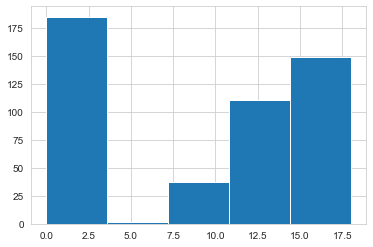

In [106]:
data_pc.hist(bins=5)

In [107]:
data_xb = data_actual.query('platform == "XOne"')['rating']

In [108]:
np.var(data_xb)

61.74892229015377

<AxesSubplot:>

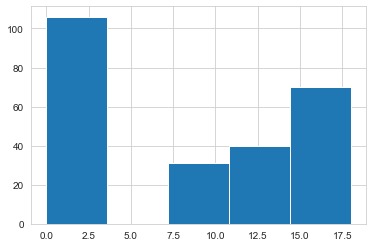

In [109]:
data_xb.hist(bins=5)

Напишем функцию:

In [110]:
def gipoteza(parametr, sign1, sign2):
    #parametr - это столбец (genre, platform), sign1 и sign2 - признаки столбца (Action, Sports и т.д.)
    data1 = data_actual.query(f'{parametr} == @sign1')['rating']
    data2 = data_actual.query(f'{parametr} == @sign2')['rating']
    results = st.ttest_ind(data1, data2)
    return results.pvalue
     

In [111]:
gipoteza('platform', 'PC', 'XOne')

0.1355949998561526

pvalue получился выше уровня значимости - значит, у нас нет оснований опровергать нулевую гипотезу

### Средние пользовательские рейтинги жанров Action Sports разные

Сформулируем гипотезы: 
- Нулевая: средние пользовательские рейтинги жанров Action и Sports одинаковые
- Альтернативная: средние пользовательские рейтинги жанров Action и Sports различаются

In [112]:
data_act = data_actual.query('genre == "Action"')['rating']

In [113]:
np.var(data_act)

56.582099285395195

<AxesSubplot:>

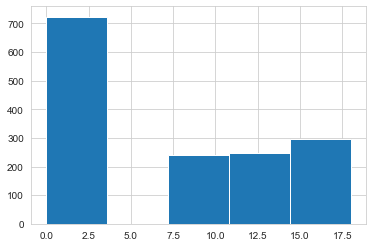

In [114]:
data_act.hist(bins=5)

In [115]:
data_sport = data_actual.query('genre == "Sports"')['rating']

In [116]:
np.var(data_sport)

22.94268302504748

<AxesSubplot:>

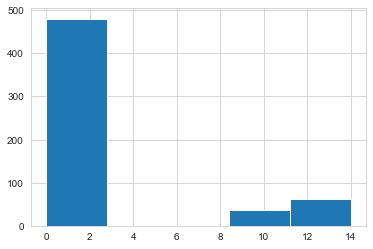

In [117]:
data_sport.hist(bins=5)

In [118]:
gipoteza('genre', 'Action', 'Sports')

1.1046602961311659e-52

Pvalue меньше уровня значимости, значит отвергаем нулевую гипотезу

## Общие выводы

1. Изучили датасет
2. Переименовали столбцы
3. Заполнили пропуски в столбце year_of_release
    - нашли одноименные игры, но на других платформах и записали в пропуски год
    - с помощью регулярного выражения нашли в названии игры год
    - оставшиеся пропуски заменили на медианы по платформам
4. Заполнили пропуски в столбце rating по максимально встречающимся в жанре
5. Посчитали суммарные продажи
6. Пострили диаграммы продаж по всем платформам и нашли актуальный период платформ, равный 6 годам - это время, с начала выхода платформы на рынок до выхода платформы следующего поколения
7. Для актуального периода изучили влияние отзывов экспретов и игроков на продажи игр. Оказалось, что между продажами и оценками экспертов есть линейная зависимость, коэф корреляции которой равен в среднем 0,35. А зависимости между продажами и оценками игроков нет. Например, игра может быть культовой или продолжением успешной серии, у нее большие продажи, а сама игра получилось не очень, в следствие чего и оценки она получила плохие
8. Нашли самые прибыльные жанры - это Action, Shooter и Sports
9. Составили портреты целовой аудитории в разных регионах мира. 
- в Америкек это взрослые люди, которые играют на приствках предпоследнего и послденего поколения в шутеры и экшены
- в Европе такая же картина, но здесь больше игроков ПК
- в Азии это подростки, играющие в различные игры на "карманных" консолях
10. Проверили гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Эту гипотезу мы не отвергли
- Средние пользовательские рейтинги жанров Action и Sports одинаковы. Это гипотезу мы отвергли

11. Самый главный вопрос проекта: какие есть закономерности, определяющие успех проекта?
    
    Ориентируясь на рынок Европы и Северной Америки, можно сделать ставку на жанры Action, Shooter или Sports, которые будут продаваться на PS4, XOne и PC. Популярные платформы PS3 и XB360 уже устарели, поэтому нет смысла продвигать продажи на этих платформах